# Style Transfer

In this notebook, we will go through basics of neural style transfer. 

Here we will use [keras](https://keras.io/  "Keras Homepage").


Everything is explained in-detail in [blog post](https://dudeperf3ct.github.io/style/transfer/2018/12/23/Magic-of-Style-Transfer/). This is notebook which replicates the result of blog and runs in colab. Enjoy!


#### Run in Colab

You can run this notebook in google colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dudeperf3ct/DL_notebooks/blob/master/Style%20Transfer/style_transfer_keras.ipynb)

In [0]:
#uncomment this to upload kaggle.json

from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

Saving forest.jpg to forest.jpg


In [0]:
#uncomment this to upload kaggle.json

from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

Saving lake.jpg to lake.jpg


In [0]:
import numpy as np
import time
import imageio
from scipy.optimize import fmin_l_bfgs_b
import tensorflow as tf
import keras
import keras.backend as K
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, save_img, img_to_array


import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

Using TensorFlow backend.


In [0]:

input_image = 'cat.jpg'
style_input_image = 'starry-night.jpg'

In [0]:
# vgg16 architecture

model = VGG16(weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
for layer in model.layers:
  print (layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [0]:
width, height = load_img(input_image).size      #input image dimension
img_nrows = 400
img_ncols = int(width * img_nrows / height)       #output image dimension

def preprocess_image(img_path):
    img = load_img(img_path, target_size=(img_nrows, img_ncols))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x


def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

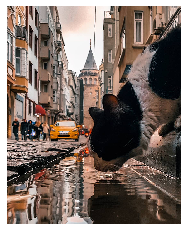

In [0]:
# content image
content = imageio.imread(input_image)
plt.xticks([])
plt.yticks([])
plt.grid(visible=False)
imshow(content)

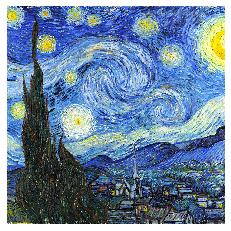

In [0]:
# style image
style = imageio.imread(style_input_image)
plt.xticks([])
plt.yticks([])
plt.grid(visible=False)
imshow(style)

In [0]:
content_image = K.variable(preprocess_image(input_image))
style_image = K.variable(preprocess_image(style_input_image))
generated_image = K.variable(np.random.randn(1, img_nrows, img_ncols, 3))

print ('Input shapes:', content_image.shape, style_image.shape, generated_image.shape)

input_tensor = K.concatenate([content_image,
                              style_image,
                              generated_image], axis=0)

model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

Input shapes: (1, 400, 320, 3) (1, 400, 320, 3) (1, 400, 320, 3)


## Gatys et al 

Paper: [Link](https://arxiv.org/pdf/1508.06576.pdf)

Code Adapted from: [Here](https://github.com/keras-team/keras/blob/master/examples/neural_style_transfer.py)

In [0]:
# content loss

def content_loss(c, g):
    return K.sum(K.square(c - g))


In [0]:
# style loss and gram matrix

def gram_matrix(x):
    
    assert K.ndim(x) == 3

    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram =  K.dot(features, K.transpose(features))

    return gram

def style_loss(s, g):
  
    assert K.ndim(s) == 3
    assert K.ndim(g) == 3  
    
    channels = 3
    size = img_nrows * img_ncols
    style_gram_matrix = gram_matrix(s)
    generated_gram_matrix = gram_matrix(g)
    
    return K.sum(K.square(style_gram_matrix - generated_gram_matrix))  / (4.0 * (channels ** 2) * (size ** 2))

In [0]:
# total loss

def total_variation_loss(x):
    
    assert K.ndim(x) == 4
    
    a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    
    return K.sum(K.pow(a + b, 1.25))


In [0]:
content_layer = 'block4_conv1'

style_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1', 
                  'block5_conv1']

alpha = 0.025
beta = 1.0
gamma = 1.0

def total_loss(content_layer, style_layers, alpha, beta, gamma):   
  
    l = 0.0
    J_content = 0
    J_style = 0
    J_total_variation = 0
    
    layer_features = outputs_dict[content_layer]
    c = layer_features[0, :, :, :]
    g = layer_features[2, :, :, :]
    J_content = alpha * content_loss(c, g)
    
    for layer_name in style_layers:
      layer_features = outputs_dict[layer_name]
      s = layer_features[1, :, :, :]
      g = layer_features[2, :, :, :]
      J_style += (beta / len(style_layers)) * style_loss(s, g)
    
    
    J_total_variation = gamma * total_variation_loss(generated_image)
    
    l = J_content + J_style + J_total_variation

    return l
  
loss = K.variable(0.0)

# total loss --> content + style + variation
loss = total_loss(content_layer, style_layers, alpha, beta, gamma)

# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, generated_image)


outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([generated_image], outputs)

In [0]:
def eval_loss_and_grads(x):
    
    x = x.reshape((1, img_nrows, img_ncols, 3))
    
    outs = f_outputs([x])
    loss_value = outs[0]
    
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    
    return loss_value, grad_values

In [0]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
      
      
evaluator = Evaluator()

In [0]:

#run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(input_image)
display_every = 2
iterations = 20

for i in range(iterations):
  
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    
    end_time = time.time()
    
    if i % display_every == 0:  
      print('Iteration %d completed in %ds' % (i, end_time - start_time))
      print('Current loss value:', min_val)

Iteration 0 completed in 8s
Current loss value: 7201644500.0
Iteration 2 completed in 7s
Current loss value: 4896485400.0
Iteration 4 completed in 7s
Current loss value: 4645134300.0
Iteration 6 completed in 7s
Current loss value: 4564697600.0
Iteration 8 completed in 7s
Current loss value: 4531865600.0
Iteration 10 completed in 7s
Current loss value: 4514638000.0
Iteration 12 completed in 7s
Current loss value: 4505869300.0
Iteration 14 completed in 7s
Current loss value: 4500276700.0
Iteration 16 completed in 7s
Current loss value: 4496263000.0
Iteration 18 completed in 7s
Current loss value: 4493477000.0


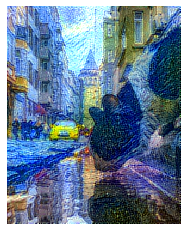

In [0]:
img = deprocess_image(x.copy())
plt.xticks([])
plt.yticks([])
plt.grid(visible=False)
imshow(img)

## Johnson et al

Paper: [Link](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf)

Code and pretrained models from: [Here](https://github.com/misgod/fast-neural-style-keras)

In [0]:
!wget 'cs231n.stanford.edu/coco-animals.zip'
!unzip 'coco-animals.zip'
!rm 'coco-animals.zip'

In [0]:
! wget 'https://raw.githubusercontent.com/misgod/fast-neural-style-keras/master/pretrained/la_muse_weights.h5'
! wget 'https://raw.githubusercontent.com/misgod/fast-neural-style-keras/master/pretrained/udnie_weights.h5'
! wget 'https://raw.githubusercontent.com/misgod/fast-neural-style-keras/master/pretrained/mirror_weights.h5'

In [0]:
import shutil, os, random
from PIL import Image

# os.mkdir('keras_models')
# shutil.move('la_muse_weights.h5', 'keras_models/la_muse_weights.h5')
# shutil.move('udnie_weights.h5', 'keras_models/udnie_weights.h5')
# shutil.move('mirror_weights.h5', 'keras_models/mirror_weights.h5')

In [0]:
# style pretrained pytorch models
print (os.listdir('keras_models/'))
random_style = random.choice(os.listdir('keras_models/'))

style_model_path = os.path.join('keras_models/', random_style)
print (random_style)

['udnie_weights.h5', 'la_muse_weights.h5', 'mirror_weights.h5']
la_muse_weights.h5


In [0]:
path = 'coco-animals/val'

random_dir = random.choice(os.listdir(path))
random_image = random.choice(os.listdir(os.path.join(path, random_dir)))
image_path = os.path.join(os.path.join(path, random_dir), random_image)
print (random_image, image_path)

COCO_val2014_000000480345.jpg coco-animals/val/giraffe/COCO_val2014_000000480345.jpg


In [0]:
#@title
from keras.regularizers import Regularizer
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.models import Model,Sequential
from keras.objectives import mean_squared_error

def dummy_loss(y_true, y_pred ):
    return K.variable(0.0)

def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_dim_ordering() == 'th':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))

    shape = K.shape(x)
    
    C, W, H = (shape[0],shape[1], shape[2])
    
    cf = K.reshape(features ,(C,-1))
    gram = K.dot(cf, K.transpose(cf)) /  K.cast(C*W*H,dtype='float32')

    return gram


class StyleReconstructionRegularizer(Regularizer):
    """ Johnson et al 2015 https://arxiv.org/abs/1603.08155 """

    def __init__(self, style_feature_target, weight=1.0):
        self.style_feature_target = style_feature_target
        self.weight = weight
        self.uses_learning_phase = False
        super(StyleReconstructionRegularizer, self).__init__()

        self.style_gram = gram_matrix(style_feature_target)

    def __call__(self, x):
        output = x.output[0] # Generated by network
        loss = self.weight *  K.sum(K.mean(K.square((self.style_gram-gram_matrix(output) )))) 

        return loss


class FeatureReconstructionRegularizer(Regularizer):
    """ Johnson et al 2015 https://arxiv.org/abs/1603.08155 """

    def __init__(self, weight=1.0):
        self.weight = weight
        self.uses_learning_phase = False
        super(FeatureReconstructionRegularizer, self).__init__()

    def __call__(self, x):
        generated = x.output[0] # Generated by network features
        content = x.output[1] # True X input features

        loss = self.weight *  K.sum(K.mean(K.square(content-generated)))
        return loss


class TVRegularizer(Regularizer):
    """ Enforces smoothness in image output. """

    def __init__(self, weight=1.0):
        self.weight = weight
        self.uses_learning_phase = False
        super(TVRegularizer, self).__init__()

    def __call__(self, x):
        assert K.ndim(x.output) == 4
        x_out = x.output
        
        shape = K.shape(x_out)
        img_width, img_height,channel = (shape[1],shape[2], shape[3])
        size = img_width * img_height * channel 
        if K.image_dim_ordering() == 'th':
            a = K.square(x_out[:, :, :img_width - 1, :img_height - 1] - x_out[:, :, 1:, :img_height - 1])
            b = K.square(x_out[:, :, :img_width - 1, :img_height - 1] - x_out[:, :, :img_width - 1, 1:])
        else:
            a = K.square(x_out[:, :img_width - 1, :img_height - 1, :] - x_out[:, 1:, :img_height - 1, :])
            b = K.square(x_out[:, :img_width - 1, :img_height - 1, :] - x_out[:, :img_width - 1, 1:, :])
        loss = self.weight * K.sum(K.pow(a + b, 1.25)) 
        return loss

In [0]:
#@title
from __future__ import print_function
from __future__ import absolute_import

import warnings

from keras.models import Model
from keras.layers import Flatten, Dense, Input
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, GlobalAveragePooling2D,GlobalMaxPooling2D
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras_applications.imagenet_utils import _obtain_input_shape 

WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'


def VGG16(include_top=False, weights='imagenet',
          input_tensor=None, input_shape=None,
          pooling=None,
          classes=1000):
    """Instantiates the VGG16 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 244)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                     require_flatten=True)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg16')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
        model.load_weights(weights_path, by_name=True)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='block5_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

In [0]:
#@title
from keras.engine.topology import Layer
from keras.layers.merge import add
from keras.engine import InputSpec
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Deconvolution2D,  Conv2D,UpSampling2D,Cropping2D
from keras.layers.advanced_activations import LeakyReLU
from keras.applications.imagenet_utils import  preprocess_input
from keras.optimizers import Adam

class InputNormalize(Layer):
    def __init__(self, **kwargs):
        super(InputNormalize, self).__init__(**kwargs)

    def build(self, input_shape):
        pass

    def compute_output_shape(self,input_shape):
        return input_shape

    def call(self, x, mask=None):
        #x = (x - 127.5)/ 127.5
        return x/255.




def conv_bn_relu(nb_filter, nb_row, nb_col,stride):   
    def conv_func(x):
        x = Conv2D(nb_filter, (nb_row, nb_col), strides=stride,padding='same')(x)
        x = BatchNormalization()(x)
        #x = LeakyReLU(0.2)(x)
        x = Activation("relu")(x)
        return x
    return conv_func



#https://keunwoochoi.wordpress.com/2016/03/09/residual-networks-implementation-on-keras/
def res_conv(nb_filter, nb_row, nb_col,stride=(1,1)):
    def _res_func(x):
        identity = Cropping2D(cropping=((2,2),(2,2)))(x)

        a = Conv2D(nb_filter, (nb_row, nb_col), strides=stride, padding='valid')(x)
        a = BatchNormalization()(a)
        #a = LeakyReLU(0.2)(a)
        a = Activation("relu")(a)
        a = Conv2D(nb_filter, (nb_row, nb_col), strides=stride, padding='valid')(a)
        y = BatchNormalization()(a)

        return  add([identity, y])

    return _res_func


def dconv_bn_nolinear(nb_filter, nb_row, nb_col,stride=(2,2),activation="relu"):
    def _dconv_bn(x):
        #TODO: Deconvolution2D
        #x = Deconvolution2D(nb_filter,nb_row, nb_col, output_shape=output_shape, subsample=stride, border_mode='same')(x)
        #x = UpSampling2D(size=stride)(x)
        x = UnPooling2D(size=stride)(x)
        x = ReflectionPadding2D(padding=stride)(x)
        x = Conv2D(nb_filter, (nb_row, nb_col), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation(activation)(x)
        return x
    return _dconv_bn




class Denormalize(Layer):
    '''
    Custom layer to denormalize the final Convolution layer activations (tanh)
    Since tanh scales the output to the range (-1, 1), we add 1 to bring it to the
    range (0, 2). We then multiply it by 127.5 to scale the values to the range (0, 255)
    '''

    def __init__(self, **kwargs):
        super(Denormalize, self).__init__(**kwargs)

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        '''
        Scales the tanh output activations from previous layer (-1, 1) to the
        range (0, 255)
        '''

        return (x + 1) * 127.5

    def compute_output_shape(self,input_shape):
        return input_shape


class VGGNormalize(Layer):
    '''
    Custom layer to subtract the outputs of previous layer by 120,
    to normalize the inputs to the VGG network.
    '''

    def __init__(self, **kwargs):
        super(VGGNormalize, self).__init__(**kwargs)

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        # No exact substitute for set_subtensor in tensorflow
        # So we subtract an approximate value       
        
        # 'RGB'->'BGR'
        x = x[:, :, :, ::-1]       
        x -= 120
        #img_util.preprocess_image(style_image_path, img_width, img_height)
        return x
   

    def compute_output_shape(self,input_shape):
        return input_shape


class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), dim_ordering='default', **kwargs):
        super(ReflectionPadding2D, self).__init__(**kwargs)

        if dim_ordering == 'default':
            dim_ordering = K.image_dim_ordering()

        self.padding = padding
        if isinstance(padding, dict):
            if set(padding.keys()) <= {'top_pad', 'bottom_pad', 'left_pad', 'right_pad'}:
                self.top_pad = padding.get('top_pad', 0)
                self.bottom_pad = padding.get('bottom_pad', 0)
                self.left_pad = padding.get('left_pad', 0)
                self.right_pad = padding.get('right_pad', 0)
            else:
                raise ValueError('Unexpected key found in `padding` dictionary. '
                                 'Keys have to be in {"top_pad", "bottom_pad", '
                                 '"left_pad", "right_pad"}.'
                                 'Found: ' + str(padding.keys()))
        else:
            padding = tuple(padding)
            if len(padding) == 2:
                self.top_pad = padding[0]
                self.bottom_pad = padding[0]
                self.left_pad = padding[1]
                self.right_pad = padding[1]
            elif len(padding) == 4:
                self.top_pad = padding[0]
                self.bottom_pad = padding[1]
                self.left_pad = padding[2]
                self.right_pad = padding[3]
            else:
                raise TypeError('`padding` should be tuple of int '
                                'of length 2 or 4, or dict. '
                                'Found: ' + str(padding))

        if dim_ordering not in {'tf'}:
            raise ValueError('dim_ordering must be in {tf}.')
        self.dim_ordering = dim_ordering
        self.input_spec = [InputSpec(ndim=4)] 


    def call(self, x, mask=None):
        top_pad=self.top_pad
        bottom_pad=self.bottom_pad
        left_pad=self.left_pad
        right_pad=self.right_pad        
        
        paddings = [[0,0],[left_pad,right_pad],[top_pad,bottom_pad],[0,0]]

        
        return tf.pad(x,paddings, mode='REFLECT', name=None)

    def compute_output_shape(self,input_shape):
        if self.dim_ordering == 'tf':
            rows = input_shape[1] + self.top_pad + self.bottom_pad if input_shape[1] is not None else None
            cols = input_shape[2] + self.left_pad + self.right_pad if input_shape[2] is not None else None

            return (input_shape[0],
                    rows,
                    cols,
                    input_shape[3])
        else:
            raise ValueError('Invalid dim_ordering:', self.dim_ordering)
            
    def get_config(self):
        config = {'padding': self.padding}
        base_config = super(ReflectionPadding2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))     
    
    
class UnPooling2D(UpSampling2D):
    def __init__(self, size=(2, 2)):
        super(UnPooling2D, self).__init__(size)

  
    def call(self, x, mask=None):
        shapes = x.get_shape().as_list() 
        w = self.size[0] * shapes[1]
        h = self.size[1] * shapes[2]
        return tf.image.resize_nearest_neighbor(x, (w,h))

        

class InstanceNormalize(Layer):
    def __init__(self, **kwargs):
        super(InstanceNormalize, self).__init__(**kwargs)
        self.epsilon = 1e-3
            

    def call(self, x, mask=None):
        mean, var = tf.nn.moments(x, [1, 2], keep_dims=True)
        return tf.div(tf.subtract(x, mean), tf.sqrt(tf.add(var, self.epsilon)))

                                                 
    def compute_output_shape(self,input_shape):
        return input_shape

In [0]:
#@title
def image_transform_net(img_width, img_height, tv_weight=1):
    x = Input(shape=(img_width,img_height,3))
    a = InputNormalize()(x)
    a = ReflectionPadding2D(padding=(40,40),input_shape=(img_width,img_height,3))(a)
    a = conv_bn_relu(32, 9, 9, stride=(1,1))(a)
    a = conv_bn_relu(64, 9, 9, stride=(2,2))(a)
    a = conv_bn_relu(128, 3, 3, stride=(2,2))(a)
    for i in range(5):
        a = res_conv(128,3,3)(a)
    a = dconv_bn_nolinear(64,3,3)(a)
    a = dconv_bn_nolinear(32,3,3)(a)
    a = dconv_bn_nolinear(3,9,9,stride=(1,1),activation="tanh")(a)
    # Scale output to range [0, 255] via custom Denormalize layer
    y = Denormalize(name='transform_output')(a)
    
    model = Model(inputs=x, outputs=y)
    
    if tv_weight > 0:
        add_total_variation_loss(model.layers[-1],tv_weight)
        
    return model 


def loss_net(x_in, trux_x_in, width, height,style_image_path,content_weight,style_weight):
    # Append the initial input to the FastNet input to the VGG inputs
    x = concatenate([x_in, trux_x_in], axis=0)
    
    # Normalize the inputs via custom VGG Normalization layer
    x = VGGNormalize(name="vgg_normalize")(x)

    vgg = VGG16(input_tensor=x)

    vgg_output_dict = dict([(layer.name, layer.output) for layer in vgg.layers[-18:]])
    vgg_layers = dict([(layer.name, layer) for layer in vgg.layers[-18:]])

    if style_weight > 0:
        add_style_loss(vgg,style_image_path , vgg_layers, vgg_output_dict, width, height,style_weight)   

    if content_weight > 0:
        add_content_loss(vgg_layers,vgg_output_dict,content_weight)

    # Freeze all VGG layers
    for layer in vgg.layers[-19:]:
        layer.trainable = False

    return vgg

def add_style_loss(vgg,style_image_path,vgg_layers,vgg_output_dict,img_width, img_height,weight):
    style_img = img_util.preprocess_image(style_image_path, img_width, img_height)
    print('Getting style features from VGG network.')

    style_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3']

    style_layer_outputs = []

    for layer in style_layers:
        style_layer_outputs.append(vgg_output_dict[layer])

    vgg_style_func = K.function([vgg.layers[-19].input], style_layer_outputs)

    style_features = vgg_style_func([style_img])

    # Style Reconstruction Loss
    for i, layer_name in enumerate(style_layers):
        layer = vgg_layers[layer_name]

        feature_var = K.variable(value=style_features[i][0])
        style_loss = StyleReconstructionRegularizer(
                            style_feature_target=feature_var,
                            weight=weight)(layer)

        layer.add_loss(style_loss)

def add_content_loss(vgg_layers,vgg_output_dict,weight):
    # Feature Reconstruction Loss
    content_layer = 'block3_conv3'
    content_layer_output = vgg_output_dict[content_layer]

    layer = vgg_layers[content_layer]
    content_regularizer = FeatureReconstructionRegularizer(weight)(layer)
    layer.add_loss(content_regularizer)


def add_total_variation_loss(transform_output_layer,weight):
    # Total Variation Regularization
    layer = transform_output_layer  # Output layer
    tv_regularizer = TVRegularizer(weight)(layer)
    layer.add_loss(tv_regularizer)

In [0]:
def load_weights(model, file_path):
    f = h5py.File(file_path)

    layer_names = [name for name in f.attrs['layer_names']]

    for i, layer in enumerate(model.layers[:31]):
        g = f[layer_names[i]]
        weights = [g[name] for name in g.attrs['weight_names']]
        layer.set_weigh
        ts(weights)

    f.close()

In [0]:
content_image = preprocess_image(image_path)
_, img_width, img_height, _ = content_image.shape

In [0]:
net = image_transform_net(img_width, img_height)
model = loss_net(net.output, net.input, img_width, img_height, "", 0, 0)

In [0]:
model.compile(Adam(),  dummy_loss)  # Dummy loss since we are learning from regularizes

model.load_weights(style_model_path, by_name=False)

In [0]:
output = net.predict(content_image)[0] 

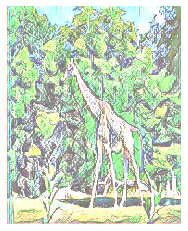

In [0]:
img = deprocess_image(output)
plt.xticks([])
plt.yticks([])
plt.grid(visible=False)
imshow(img)

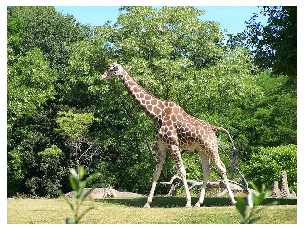

In [0]:
img = Image.open(image_path)
plt.xticks([])
plt.yticks([])
plt.grid(visible=False)
imshow(img)